# COVID-19 Vaccine Twitter Modeling

## Contents
1. [Imports](#1.-Imports)
2. [Load Preprocessed Data](#2.-Load-Preprocessed-Data)
3. [Model 1: Restricted/Nested Model](#3.-Model-1:-Restricted/Nested-Model)
    * [3.1 Baseline Accuracy](#3.1-Baseline-Accuracy)
    * [3.2 Hyperparameter Tuning](#3.2-Hyperparameter-Tuning)
    * [3.3 Results](#3.3-Results)
4. [Model 2: Full Model](#4.-Model-2:-Full-Model)
    * [4.1 Baseline Accuracy](#4.1-Baseline-Accuracy)
    * [4.2 Hyperparameter Tuning](#4.2-Hyperparameter-Tuning)
    * [4.3 Results](#4.3-Results)
5. [Model 3: 2-Step Model/Pipeline System](#5.-Model-3:-2-Step-Model/Pipeline-System)
    * [5.1 Pipeline (step 1): Subjectivity Classifier](#5.1-Pipeline-(step-1):-Subjectivity-Classifier)
        * [5.1.1 Algorithms Comparison](#5.1.1-Algorithms-Comparison)
        * [5.1.2 Logistic Regression](#5.1.2-Logistic-Regression)
        * [5.1.3 Ridge Classifier](#5.1.3-Ridge-Classifier)
        * [5.1.4 Ensemble - Voting Classifier](#5.1.4-Ensemble---Voting-Classifier)    
        * [5.1.5 Results](#5.1.5-Results)
    * [5.2 Pipeline (step 2): Sentiment Classifier](#5.2-Pipeline-(step-2):-Sentiment-Classifier)
    * [5.3 Full System Summary (step 1 & step 2)](#5.3-Full-System-Summary-(step-1-&-step-2))
        * [5.3.1 Aggregating Metrics](#5.3.1-Aggregating-Metrics)
        * [5.3.2 Results](#5.3.2-Results)
6. [Performance Metrics Evaluation](#6.-Performance-Metrics-Evaluation)

## 1. Imports

In [2]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import itertools
import shap
import eli5
import nltk
import contractions
import dataframe_image as dfi
from bs4 import BeautifulSoup
from collections import Counter
from math import log
import kds
import nltk
# nltk.download('wordnet')
# nltk.download('punkt')
# nltk.download('vader_lexicon')
from nltk.tokenize import word_tokenize,TweetTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.linear_model import LogisticRegression,RidgeClassifier
from sklearn.metrics import classification_report,confusion_matrix,make_scorer,accuracy_score,precision_score,recall_score,f1_score,roc_curve,auc,precision_recall_fscore_support
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC,SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,VotingClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.neighbors import KNeighborsClassifier
from string import punctuation
# from tortus import Tortus
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

## 2. Load Preprocessed Data

In [3]:
# Load the preprocessed data: 'covidvaccine_preprocessed.csv'
df = pd.read_csv('../data/covidvaccine_preprocessed.csv')

In [4]:
df.shape

(124427, 16)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124427 entries, 0 to 124426
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   user_name         124427 non-null  object 
 1   user_location     98969 non-null   object 
 2   user_description  117980 non-null  object 
 3   user_created      124427 non-null  object 
 4   user_followers    124427 non-null  float64
 5   user_friends      124427 non-null  float64
 6   user_favourites   124427 non-null  float64
 7   user_verified     124427 non-null  bool   
 8   date              124427 non-null  object 
 9   text              124427 non-null  object 
 10  hashtags          124427 non-null  object 
 11  source            123364 non-null  object 
 12  is_retweet        124427 non-null  bool   
 13  clean_hashtags    124427 non-null  object 
 14  clean_text        124427 non-null  object 
 15  clean_tweets      124427 non-null  object 
dtypes: bool(2), float64(

In [6]:
# Set 'date' and 'user_created' columns as Datetime
df['date'] = pd.to_datetime(df.date)
df['user_created'] = pd.to_datetime(df.user_created)

In [7]:
df.dtypes

user_name                   object
user_location               object
user_description            object
user_created        datetime64[ns]
user_followers             float64
user_friends               float64
user_favourites            float64
user_verified                 bool
date                datetime64[ns]
text                        object
hashtags                    object
source                      object
is_retweet                    bool
clean_hashtags              object
clean_text                  object
clean_tweets                object
dtype: object

In [8]:
# Check for duplicates
df[df.duplicated(['clean_tweets'],keep=False)].sort_values('clean_tweets')

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet,clean_hashtags,clean_text,clean_tweets


## 3. Model 1: Restricted/Nested Model

**Labels: Negative, Neutral, Positive**

<br>

***
- **Note:** Facts/Announcements were labeled as having Neutral sentiment.
***

### 3.1 Baseline Accuracy

In [9]:
df_factop1k = pd.read_csv('../data/1000_lab6.csv')
factop1k_cleaned = df_factop1k[['clean_tweets','label','classes','classes2']]
factop1k_cleaned2 = factop1k_cleaned.copy()
factop1k_cleaned2['classes2'] = factop1k_cleaned2['classes2'].replace(3,1)

factop1k_counts1 = pd.DataFrame({'count':factop1k_cleaned2['classes2'].value_counts(),'%':factop1k_cleaned2['classes2'].value_counts(normalize=True)})
base1 = factop1k_counts1['%'].max()

print("Baseline Accuracy = %0.2f %%"%(base1*100))
factop1k_counts1

Baseline Accuracy = 57.90 %


,count,%
1,579,0.579
2,324,0.324
0,97,0.097


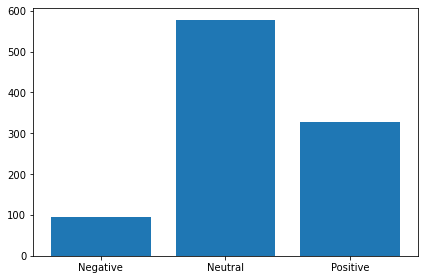

In [10]:
xy1 = {'Negative':96,'Neutral':577,'Positive':327}
plt.bar(xy1.keys(),xy1.values())
plt.tight_layout();

<br>

***
- **Note:** There seems to be a large class imbalance in the distribution of the data. 
     - The largest (majority) class size was Neutral Sentiment with 576 occurences while Negative Sentiment (the minority class) had only 97 occurences.
     - There could be a problem with our labels.
     - This could partly be the result of labeling news-related tweets into the Neutral class. In the next section, I will explore the full model that has a separate class for facts/announcements.
***

In [11]:
X1 = factop1k_cleaned2.clean_tweets
y1 = factop1k_cleaned2.classes2

corpus_train1,corpus_test1,y_train1,y_test1 = train_test_split(X1,y1,test_size=0.3,random_state=3)

In [12]:
labels = ['Negative','Neutral','Positive']

# Function to plot confusion matrix
def confusion_mat(y_test,y_pred,labels):
    cm = confusion_matrix(y_test,y_pred)
    cm_normalize = cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]

    fig,ax = plt.subplots(1,2,figsize=(10,4))
    sns.heatmap(cm,annot=True,fmt='g',cmap='Blues',ax=ax[0])
    sns.heatmap(cm_normalize,annot=True,fmt='.2',cmap='Blues',ax=ax[1])

    # labels, title, xticks, yticks
    ax[0].set_xlabel('Predicted label')
    ax[0].set_ylabel('True label') 
    ax[0].set_title('Confusion Matrix, without normalization')
    ax[0].xaxis.set_ticklabels(labels) 
    ax[0].yaxis.set_ticklabels(labels)
    ax[1].set_xlabel('Predicted label')
    ax[1].set_ylabel('True label') 
    ax[1].set_title('Normalized Confusion Matrix')
    ax[1].xaxis.set_ticklabels(labels) 
    ax[1].yaxis.set_ticklabels(labels)
    plt.tight_layout()
    plt.show(); 

TfidfVect - LOGISTIC REGRESSION MODEL: 

              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00        24
     Neutral       0.77      0.97      0.86       185
    Positive       0.90      0.66      0.76        91

    accuracy                           0.80       300
   macro avg       0.56      0.54      0.54       300
weighted avg       0.75      0.80      0.76       300



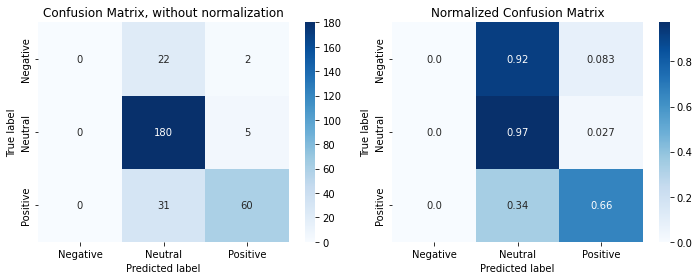

In [13]:
print('TfidfVect - LOGISTIC REGRESSION MODEL: \n')
tfidf = TfidfVectorizer()

X_train_tfidf_base = tfidf.fit_transform(corpus_train1)
X_test_tfidf_base = tfidf.transform(corpus_test1)

tfidf_lr_base = LogisticRegression()
tfidf_lr_base.fit(X_train_tfidf_base,y_train1)

y_pred_tfidf_base = tfidf_lr_base.predict(X_test_tfidf_base)

print(classification_report(y_test1,y_pred_tfidf_base,target_names=labels))
confusion_mat(y_test1,y_pred_tfidf_base,labels)

### 3.2 Hyperparameter Tuning

In [14]:
# Define pipeline
tfidf_lr_pipeline1 = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('lr', LogisticRegression())
])

grid_params1 = {
    'tfidf__stop_words': [None],
    'tfidf__max_df': [0.8],
    'tfidf__ngram_range': [(1,1),(1,2)],
    'tfidf__binary': [True],
    'lr__C': [0.1,1,10,100],
    'lr__solver': ['liblinear'],
    'lr__penalty': ['l2'],
    'lr__class_weight': ['balanced']
}

gs_tfidf_lr1 = GridSearchCV(tfidf_lr_pipeline1,param_grid=grid_params1,cv=5,n_jobs=-1,verbose=1,scoring='accuracy')
gs_tfidf_lr1.fit(corpus_train1,y_train1)

print("Best Score: ",gs_tfidf_lr1.best_score_)
print("Best Paramaters: ",gs_tfidf_lr1.best_params_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best Score:  0.71
Best Paramaters:  {'lr__C': 1, 'lr__class_weight': 'balanced', 'lr__penalty': 'l2', 'lr__solver': 'liblinear', 'tfidf__binary': True, 'tfidf__max_df': 0.8, 'tfidf__ngram_range': (1, 1), 'tfidf__stop_words': None}


              precision    recall  f1-score   support

    Negative       0.60      0.12      0.21        24
     Neutral       0.79      0.96      0.87       185
    Positive       0.90      0.69      0.78        91

    accuracy                           0.81       300
   macro avg       0.76      0.59      0.62       300
weighted avg       0.81      0.81      0.79       300



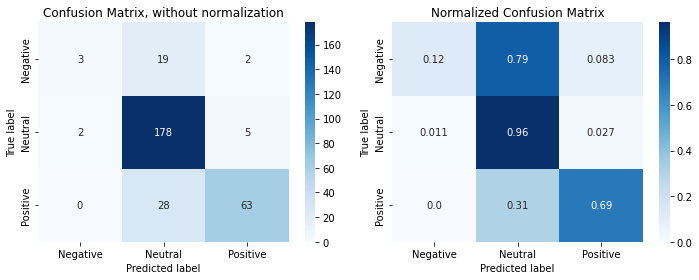

In [15]:
# Best TF-IDF/LogReg hyper parameters
best_model1 = gs_tfidf_lr1.best_estimator_
y_pred_best_model1 = best_model1.predict(corpus_test1)

# print(tfidf_gs_best.score(corpus_test, y_test))
print(classification_report(y_test1,y_pred_best_model1,target_names=labels))
confusion_mat(y_test1,y_pred_best_model1,labels)

# cm1 = confusion_matrix(y_test1,y_pred_best_model1,normalize='true')
# plt.title("Model 1: Normalized Confusion Matrix")
# ax = sns.heatmap(cm1,annot=True,fmt='.2',cmap='Blues',yticklabels=labels,xticklabels=labels)
# ax.set(xlabel='Predicted label',ylabel='True label')
# # plt.savefig('../images/cm_image1.png')

### 3.3 Results

In [16]:
acc1 = accuracy_score(y_test1,y_pred_best_model1)
f1_mac1 = f1_score(y_test1,y_pred_best_model1,average='macro')
f1_w1 = f1_score(y_test1,y_pred_best_model1,average='weighted')
miss1 = 1-acc1
base_actual1 = round((acc1-base1)*100,2)

print("MODEL 1 SUMMARY -- Nested/Restricted Sentiment Model:\n")
print('Null Accuracy (baseline):  ',base1.round(3))
print('Accuracy (test data):  ',acc1.round(3))
print('F1 Score (macro):  ',f1_mac1.round(3))
print('F1 Score (weighted):  ',f1_w1.round(3))
print('Misclassification Error-Rate:  ',miss1.round(3))
print("\nModel 1's accuracy on the test data is %0.2f%% better than the theoretical baseline (null accuracy)"%(base_actual1))

MODEL 1 SUMMARY -- Nested/Restricted Sentiment Model:

Null Accuracy (baseline):   0.579
Accuracy (test data):   0.813
F1 Score (macro):   0.619
F1 Score (weighted):   0.789
Misclassification Error-Rate:   0.187

Model 1's accuracy on the test data is 23.43% better than the theoretical baseline (null accuracy)


<br>

***

- **Note:** After tuning, Model 1 performed pretty quite well with test accuracy of 73%.
    - However, it seems like it has a hard time predicting Negative sentiment.
    - In the test set, the model accuractely predicted negative tweets 12%. 
    - Also, 71% of actual Negative tweets were predicted as Neutral. 




***

- **Questions to think about:** Should there be a separate class for Fact/Announcements and News-related tweets?
     - Facts/Announcements/News generally does not convey user sentiment and there is a distinction to tweets that carry Neutral Sentiment.
     - The Neutral Sentiment class contained tweets where users either agreed or disagreed with the covid vaccination program. Tweets where users expressed that they may or may not consider vaccination were also marked as Neutral. 
     
***

## 4. Model 2: Full Model

**Labels: Negative, Neutral, Positive, Fact/Announcements**

<br>

***
- **Note:** Separate class for Fact/Announcements
    - Higher-level model than the Model 1
    - Model 1 is nested within Model 2
    - Generally (but not always), nested/restricted models perform better than its full model. Full models are more complex than the reduced model and have one or more parameters which is, inherently, accompanied by random noise. 
***

In [17]:
# Train/test split
X2 = factop1k_cleaned.clean_tweets
y2 = factop1k_cleaned.classes2

corpus_train2,corpus_test2,y_train2,y_test2 = train_test_split(X2,y2,test_size=0.3,random_state=3)

### 4.1 Baseline Accuracy

In [18]:
factop1k_counts2 = pd.DataFrame({'count':factop1k_cleaned['classes2'].value_counts(),'%':factop1k_cleaned['classes2'].value_counts(normalize=True)})
base2 = factop1k_counts2['%'].max()

print("Baseline Accuracy = %0.2f %%"%(base2*100))
factop1k_counts2

Baseline Accuracy = 42.70 %


,count,%
3,427,0.427
2,324,0.324
1,152,0.152
0,97,0.097


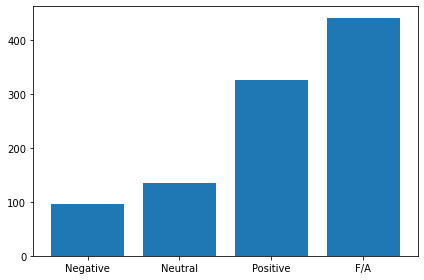

In [19]:
xy2 = {'Negative':96, 'Neutral':136,'Positive':327,'F/A':441}
plt.bar(xy2.keys(),xy2.values())
plt.tight_layout();

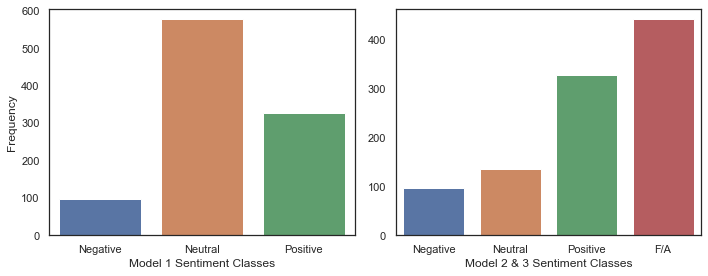

In [20]:
xy1_df = pd.DataFrame(xy1.keys(),xy1.values()).reset_index()
xy2_df = pd.DataFrame(xy2.keys(),xy2.values()).reset_index()

sns.set(style='white')
fig, ax = plt.subplots(1,2,figsize=(10,4))
sns.barplot(data=xy1_df,x=0,y="index", ax=ax[0])
sns.barplot(data=xy2_df,x=0,y="index", ax=ax[1])

ax[0].set_xlabel('Model 1 Sentiment Classes')
ax[0].set_ylabel('Frequency')
ax[1].set_xlabel('Model 2 & 3 Sentiment Classes') 
ax[1].set(ylabel=None)
plt.tight_layout();
# plt.savefig('../images/models_classes.png')

<br>

***
- **Note:** By adding a class for Facts/Announcements, the Neutral class size was reduced from 576 to 136.
     - 441 were facts/news-related tweets
***

TfidfVect - LOGISTIC REGRESSION MODEL:

LABELS: Negative, Neutral, Positive, Fact/Announcements

              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00        24
     Neutral       0.75      0.05      0.10        58
    Positive       0.70      0.73      0.71        91
         F/A       0.60      0.95      0.74       127

    accuracy                           0.63       300
   macro avg       0.51      0.43      0.39       300
weighted avg       0.61      0.63      0.55       300



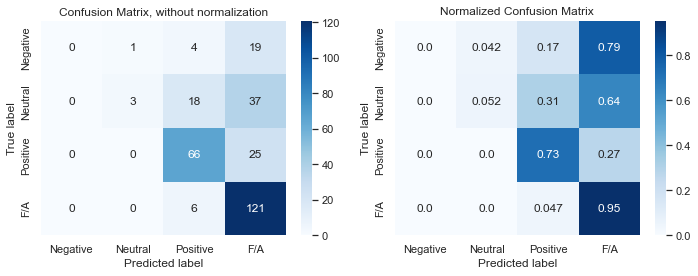

In [21]:
labels2=['Negative','Neutral','Positive','F/A']

print('TfidfVect - LOGISTIC REGRESSION MODEL:\n')
print('LABELS: Negative, Neutral, Positive, Fact/Announcements\n')
tfidf2 = TfidfVectorizer()

X_train_tfidf_base2 = tfidf2.fit_transform(corpus_train2)
X_test_tfidf_base2 = tfidf2.transform(corpus_test2)

tfidf_lr_base2 = LogisticRegression()
tfidf_lr_base2.fit(X_train_tfidf_base2,y_train2)

y_pred_tfidf_base2 = tfidf_lr_base2.predict(X_test_tfidf_base2)

print(classification_report(y_test2,y_pred_tfidf_base2,target_names=labels2))
confusion_mat(y_test2,y_pred_tfidf_base2,labels2)

### 4.2 Hyperparameter Tuning

In [22]:
# Define pipeline
pipeline2 = Pipeline([
    ('tfidf',TfidfVectorizer()),
    ('lr',LogisticRegression())
])

grid_params2 = {
    'tfidf__stop_words': [None],
    'tfidf__max_df': [0.8],
    'tfidf__ngram_range': [(1,1),(1,2)],
    'tfidf__binary': [True],
    'tfidf__use_idf': [True],
    'tfidf__smooth_idf': [True],
    'tfidf__norm': ['l2'],
    'lr__C': [0.1,1,10,100],
    'lr__solver': ['newton-cg'],
    'lr__class_weight': ['balanced']
}

gs_pipe2 = GridSearchCV(pipeline2,param_grid=grid_params2,cv=5,n_jobs=-1,verbose=1,scoring='accuracy')
gs_pipe2.fit(corpus_train2,y_train2)

print("Best Score: ",gs_pipe2.best_score_)
print("Best Paramaters: ",gs_pipe2.best_params_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best Score:  0.6114285714285714
Best Paramaters:  {'lr__C': 1, 'lr__class_weight': 'balanced', 'lr__solver': 'newton-cg', 'tfidf__binary': True, 'tfidf__max_df': 0.8, 'tfidf__ngram_range': (1, 2), 'tfidf__norm': 'l2', 'tfidf__smooth_idf': True, 'tfidf__stop_words': None, 'tfidf__use_idf': True}


              precision    recall  f1-score   support

    Negative       0.42      0.33      0.37        24
     Neutral       0.63      0.38      0.47        58
    Positive       0.69      0.79      0.74        91
         F/A       0.77      0.87      0.82       127

    accuracy                           0.71       300
   macro avg       0.63      0.59      0.60       300
weighted avg       0.69      0.71      0.69       300



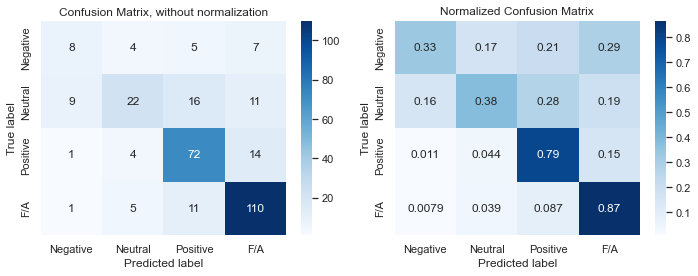

In [23]:
model_best2 = gs_pipe2.best_estimator_
y_pred_best2 = model_best2.predict(corpus_test2)

# print(model_best2.score(corpus_test2,y_test2))
print(classification_report(y_test2,y_pred_best2,target_names=labels2))
confusion_mat(y_test2,y_pred_best2,labels2)

# cm2 = confusion_matrix(y_test2,y_pred_best2,normalize='true')
# plt.title("Model 2: Normalized Confusion Matrix")
# ax = sns.heatmap(cm2,annot=True,fmt='.2',cmap='Blues',yticklabels=labels2,xticklabels=labels2)
# ax.set(xlabel='Predicted label',ylabel='True label')
# # plt.savefig('../images/cm_image2.png')

### 4.3 Results

In [24]:
acc2 = accuracy_score(y_test2,y_pred_best2)
f1_mac2 = f1_score(y_test2,y_pred_best2,average='macro')
f1_w2 = f1_score(y_test2,y_pred_best2,average='weighted')
miss2 = 1-acc2
base_actual2 = round((acc2-base2)*100,2)

print("MODEL 2 SUMMARY -- Full Sentiment Model:\n")
print('Null Accuracy (baseline):  ',base2.round(3))
print('Accuracy (test data):  ',acc2.round(3))
print('F1 Score (macro):  ',f1_mac2.round(3))
print('F1 Score (weighted):  ',f1_w2.round(3))
print('Misclassification Error-Rate:  ',miss2.round(3))
print("\nModel 2's accuracy on the test data is %0.2f%% better than the theoretical baseline (null accuracy)"%(base_actual2))

MODEL 2 SUMMARY -- Full Sentiment Model:

Null Accuracy (baseline):   0.427
Accuracy (test data):   0.707
F1 Score (macro):   0.6
F1 Score (weighted):   0.691
Misclassification Error-Rate:   0.293

Model 2's accuracy on the test data is 27.97% better than the theoretical baseline (null accuracy)


## 5. Model 3: 2-Step Model/Pipeline System

***
- **Note:** Model 3 is a 2 step pipeline approach.
    - In step 1, classify if a tweet is a fact or opinion. 
    - In step 2, feed the predicted opinions into the sentiment model.
***

### 5.1 Pipeline (step 1): Subjectivity Classifier

**Labels: Fact/Announcements, Opinions**

In [25]:
factop1k_counts3 = pd.DataFrame({'count':factop1k_cleaned['classes'].value_counts(),'%':factop1k_cleaned['classes'].value_counts(normalize=True)})
base3a = factop1k_counts3['%'].max()

print("Baseline Accuracy = %0.2f %%"%(base3a*100))
factop1k_counts3

Baseline Accuracy = 57.30 %


,count,%
1,573,0.573
0,427,0.427


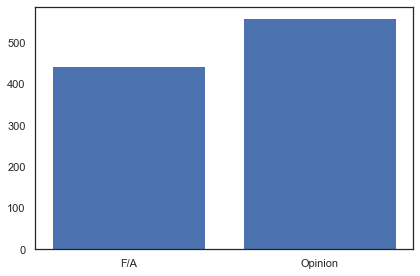

In [26]:
xy3a = {'F/A':442,'Opinion':558}
plt.bar(xy3a.keys(),xy3a.values())
plt.tight_layout();

In [27]:
# Train/test split
X3 = factop1k_cleaned.clean_tweets
y3 = factop1k_cleaned.classes

corpus_train3,corpus_test3,y_train3,y_test3 = train_test_split(X3,y3,test_size=0.3,random_state=3)

In [28]:
labels3=['F/A','Opinions']

def get_preds(threshold,probabilities):
    return [1 if prob>threshold else 0 for prob in probabilities]

def plot_roc_auc(y_pred_prob):
    roc_values = []
    for thresh in np.linspace(0,1,100):
        preds = get_preds(thresh,y_pred_prob[:,1])
        tn,fp,fn,tp = confusion_matrix(y_test3,preds).ravel()
        tpr = tp/(tp+fn)
        fpr = fp/(fp+tn)
        roc_values.append([tpr,fpr])
    tpr_values,fpr_values = zip(*roc_values)
    fig,ax = plt.subplots(figsize=(7,5))
    ax.plot(fpr_values,tpr_values,color='darkorange',
             lw=2,label='ROC curve (area = %0.2f)'%auc(fpr_values,tpr_values))
    ax.plot(np.linspace(0,1,100),np.linspace(0,1,100),color='navy',lw=2,linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show();

### 5.1.1 Algorithms Comparison

In [29]:
tfidf3 = TfidfVectorizer()
X_train_tfidf_base3 = tfidf3.fit_transform(corpus_train3)
X_test_tfidf_base3 = tfidf3.transform(corpus_test3)

clfs = [LogisticRegression(),DecisionTreeClassifier(),RandomForestClassifier(),KNeighborsClassifier(),GradientBoostingClassifier(),MultinomialNB(),RidgeClassifier()]
clfs_names = ['Logistic Regression','Decision Tree','Random Forest','KNN','Gradient Boosting','Multinomial NB','Ridge']
zipped_clfs = zip(clfs_names,clfs)

for clf in clfs:
    clf.fit(X_train_tfidf_base3,y_train3)
    clf_pred = clf.predict(X_test_tfidf_base3)
    clf_score = accuracy_score(y_test3,clf_pred)
    print(clf,"Score: %0.3f"%clf_score)

LogisticRegression() Score: 0.807
DecisionTreeClassifier() Score: 0.680
RandomForestClassifier() Score: 0.757
KNeighborsClassifier() Score: 0.690
GradientBoostingClassifier() Score: 0.733
MultinomialNB() Score: 0.720
RidgeClassifier() Score: 0.817


### 5.1.2 Logistic Regression

TfidfVect - LOGISTIC REGRESSION MODEL:

              precision    recall  f1-score   support

         F/A       0.85      0.66      0.74       127
    Opinions       0.79      0.91      0.84       173

    accuracy                           0.81       300
   macro avg       0.82      0.79      0.79       300
weighted avg       0.81      0.81      0.80       300



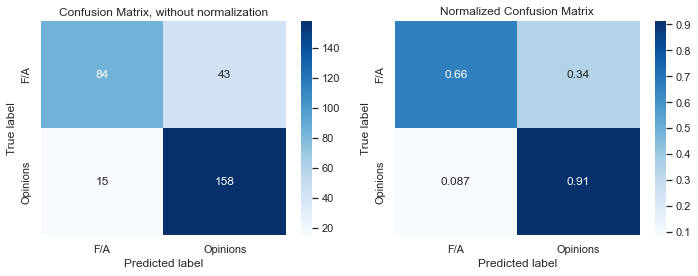

ROC-AUC = 0.90


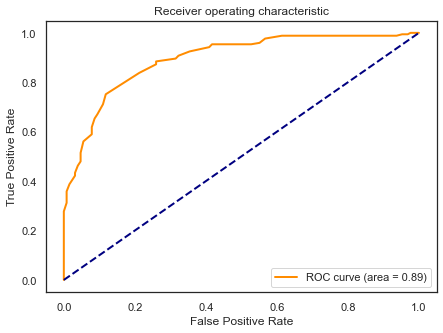

In [30]:
print('TfidfVect - LOGISTIC REGRESSION MODEL:\n')

tfidf_lr_base3 = LogisticRegression()
tfidf_lr_base3.fit(X_train_tfidf_base3,y_train3)

y_pred_tfidf_base3 = tfidf_lr_base3.predict(X_test_tfidf_base3)

print(classification_report(y_test3,y_pred_tfidf_base3,target_names=labels3))
confusion_mat(y_test3,y_pred_tfidf_base3,labels3)

y_pred_prob3 = tfidf_lr_base3.predict_proba(X_test_tfidf_base3)
fpr,tpr,thresholds = roc_curve(y_test3,y_pred_prob3[:,1],pos_label=1)
roc_auc = auc(fpr,tpr)

print("ROC-AUC = {:0.2f}".format(roc_auc))

plot_roc_auc(y_pred_prob3)

In [31]:
# Define pipeline
pipeline3a = Pipeline([
    ('tfidf',TfidfVectorizer()),
    ('lr',LogisticRegression())
])

grid_params3a = {
    'tfidf__max_df': [0.8],
    'tfidf__ngram_range': [(1,1),(1,2)],
    'tfidf__binary': [True],
    'tfidf__norm': ['l2'],
    'lr__C': [0.1,1,10,100],
    'lr__solver': ['liblinear']
}

gs_pipe3a = GridSearchCV(pipeline3a,param_grid=grid_params3a,cv=5,n_jobs=-1,verbose=1,scoring='accuracy')
gs_pipe3a.fit(corpus_train3,y_train3)

print("Best Score: ",gs_pipe3a.best_score_)
print("Best Paramaters: ",gs_pipe3a.best_params_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best Score:  0.74
Best Paramaters:  {'lr__C': 100, 'lr__solver': 'liblinear', 'tfidf__binary': True, 'tfidf__max_df': 0.8, 'tfidf__ngram_range': (1, 2), 'tfidf__norm': 'l2'}


              precision    recall  f1-score   support

         F/A       0.83      0.72      0.77       127
    Opinions       0.81      0.89      0.85       173

    accuracy                           0.82       300
   macro avg       0.82      0.80      0.81       300
weighted avg       0.82      0.82      0.81       300



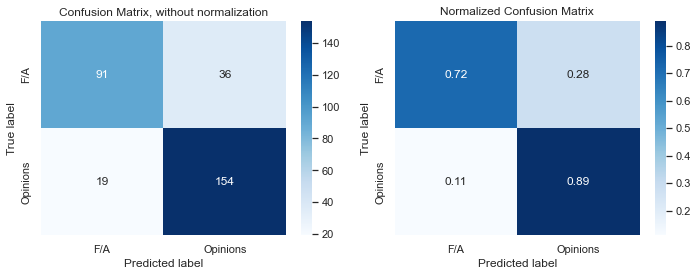

ROC-AUC = 0.90


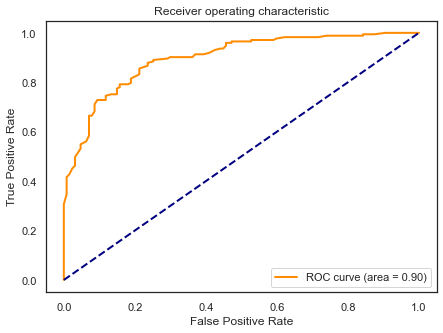

In [32]:
model_best3a = gs_pipe3a.best_estimator_
y_pred_best3a = model_best3a.predict(corpus_test3)

# print(model_best2.score(corpus_test2,y_test2))
print(classification_report(y_test3,y_pred_best3a,target_names=labels3))
confusion_mat(y_test3,y_pred_best3a,labels3)

ypredprob_best3a = model_best3a.predict_proba(corpus_test3)
fpr,tpr,thresholds = roc_curve(y_test3,ypredprob_best3a[:,1],pos_label=1)
roc_auc = auc(fpr,tpr)

print("ROC-AUC = {:0.2f}".format(roc_auc))

plot_roc_auc(ypredprob_best3a)

In [33]:
acc3a1 = accuracy_score(y_test3,y_pred_best3a)
f1_mac3a1 = f1_score(y_test3,y_pred_best3a,average='macro')
f1_w3a1 = f1_score(y_test3,y_pred_best3a,average='weighted')
miss3a1 = 1-acc3a1
base_actual3a1 = round((acc3a1-base3a)*100,2)

print("MODEL 3A SUMMARY -- LOGISTIC REGRESSION:\n")
print('Null Accuracy (baseline):  ',base3a.round(3))
print('Accuracy (test data):  ',acc3a1.round(3))
print('F1 Score (macro):  ',f1_mac3a1.round(3))
print('F1 Score (weighted):  ',f1_w3a1.round(3))
print('Misclassification Error-Rate:  ',miss3a1.round(3))
print("\nModel 3a's accuracy on the test data is %0.2f%% better than the theoretical baseline (null accuracy)"%(base_actual3a1))

MODEL 3A SUMMARY -- LOGISTIC REGRESSION:

Null Accuracy (baseline):   0.573
Accuracy (test data):   0.817
F1 Score (macro):   0.808
F1 Score (weighted):   0.814
Misclassification Error-Rate:   0.183

Model 3a's accuracy on the test data is 24.37% better than the theoretical baseline (null accuracy)


### 5.1.3 Ridge Classifier

In [34]:
print('TfidfVect - RIDGE CLASSIFIER:\n')
tfidf3 = TfidfVectorizer()

X_train_tfidf_base3 = tfidf3.fit_transform(corpus_train3)
X_test_tfidf_base3 = tfidf3.transform(corpus_test3)

tfidf_ridge = RidgeClassifier()
tfidf_ridge.fit(X_train_tfidf_base3,y_train3)

y_pred_tfidf_base3 = tfidf_ridge.predict(X_test_tfidf_base3)

print('TEST-ACCURACY: {:.2f}'.format(accuracy_score(y_test3,y_pred_tfidf_base3)))

# print(classification_report(y_test3, y_pred_tfidf_base3, target_names=labels3))
# confusion_mat(y_test3, y_pred_tfidf_base3, labels3)

TfidfVect - RIDGE CLASSIFIER:

TEST-ACCURACY: 0.82


In [35]:
# Define pipeline
pipeline3b = Pipeline([
    ('tfidf',TfidfVectorizer()),
    ('ridge',RidgeClassifier())
])

grid_params3b = {
    'tfidf__stop_words': [None],
    'tfidf__max_df': [0.8],
    'tfidf__ngram_range': [(1,1),(1,2)],
    'tfidf__binary': [True],
    'tfidf__use_idf': [True],
    'tfidf__smooth_idf': [True],
    'tfidf__norm': ['l2','l1'],
    'ridge__alpha': [0.001,0.01,0.1,1]
}

gs_pipe3b = GridSearchCV(pipeline3b,param_grid=grid_params3b,cv=5,n_jobs=-1,verbose=1,scoring='accuracy')
gs_pipe3b.fit(corpus_train3,y_train3)

print("Best Score: ",gs_pipe3b.best_score_)
print("Best Paramaters: ",gs_pipe3b.best_params_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best Score:  0.74
Best Paramaters:  {'ridge__alpha': 0.1, 'tfidf__binary': True, 'tfidf__max_df': 0.8, 'tfidf__ngram_range': (1, 2), 'tfidf__norm': 'l2', 'tfidf__smooth_idf': True, 'tfidf__stop_words': None, 'tfidf__use_idf': True}


              precision    recall  f1-score   support

         F/A       0.81      0.75      0.78       127
    Opinions       0.83      0.87      0.85       173

    accuracy                           0.82       300
   macro avg       0.82      0.81      0.81       300
weighted avg       0.82      0.82      0.82       300



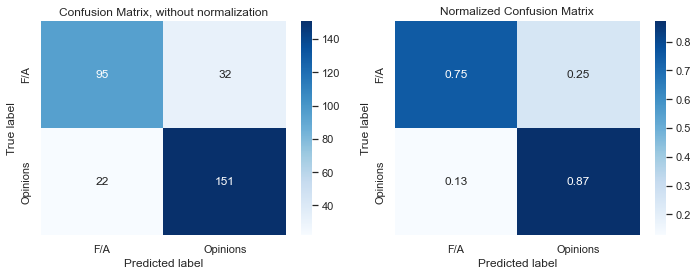

In [36]:
model_best3b = gs_pipe3b.best_estimator_
y_pred_best3b = model_best3b.predict(corpus_test3)

# print(model_best2.score(corpus_test2, y_test2))
print(classification_report(y_test3,y_pred_best3b,target_names=labels3))
confusion_mat(y_test3,y_pred_best3b,labels3)

In [37]:
acc3a2 = accuracy_score(y_test3,y_pred_best3b)
f1_mac3a2 = f1_score(y_test3,y_pred_best3b,average='macro')
f1_w3a2 = f1_score(y_test3,y_pred_best3b,average='weighted')
miss3a2 = 1-acc3a2
base_actual3a2 = round((acc3a2-base3a)*100,2)

print("MODEL 3A SUMMARY -- RIDGE CLASSIFIER:\n")
print('Null Accuracy (baseline):  ',base3a.round(3))
print('Accuracy (test data):  ',acc3a2.round(3))
print('F1 Score (macro):  ',f1_mac3a2.round(3))
print('F1 Score (weighted):  ',f1_w3a2.round(3))
print('Misclassification Error-Rate:  ',miss3a2.round(3))
print("\nModel 3a's accuracy on the test data is %0.2f%% better than the theoretical baseline  (null accuracy)"%(base_actual3a2))

MODEL 3A SUMMARY -- RIDGE CLASSIFIER:

Null Accuracy (baseline):   0.573
Accuracy (test data):   0.82
F1 Score (macro):   0.814
F1 Score (weighted):   0.819
Misclassification Error-Rate:   0.18

Model 3a's accuracy on the test data is 24.70% better than the theoretical baseline  (null accuracy)


### 5.1.4 Ensemble - Voting Classifier

In [38]:
print('TfidfVect - VOTING CLASSIFIER:\n')

tfidf4 = TfidfVectorizer(max_df=0.8,ngram_range=(1,2),binary=True,norm='l2',smooth_idf=True,use_idf=True)
X_train_tfidf_base4 = tfidf.fit_transform(corpus_train3)
X_test_tfidf_base4 = tfidf.transform(corpus_test3)

clf_lr = LogisticRegression()
clf_dt = DecisionTreeClassifier(random_state=7)
clf_svm = SVC(random_state=7)

vestimators = [('lr',clf_lr), 
              ('dt',clf_dt), 
              ('svm',clf_svm)]

vclf = VotingClassifier(estimators=vestimators,voting='hard')
vclf.fit(X_train_tfidf_base4,y_train3)
vclf_pred = vclf.predict(X_test_tfidf_base4)

# Evaluate model performance
vclf_acc = accuracy_score(y_test3,vclf_pred)
print('TEST-ACCURACY: {:.2f}'.format(vclf_acc))

TfidfVect - VOTING CLASSIFIER:

TEST-ACCURACY: 0.82


In [39]:
vparams = {'lr__C': [0.01,0.1,1,100],
          'lr__class_weight': ['balanced'],
          'dt__min_samples_leaf': [3],
          'dt__min_samples_split': [15],
          'svm__probability': [True],
          'svm__class_weight': ['balanced']}

vgrid = GridSearchCV(vclf,param_grid=vparams,cv=5,n_jobs=-1,verbose=1,scoring='precision')
vgrid.fit(X_train_tfidf_base4,y_train3)

print("Best Score: ",vgrid.best_score_)
print("Best Paramaters: ",vgrid.best_params_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best Score:  0.7696444251148455
Best Paramaters:  {'dt__min_samples_leaf': 3, 'dt__min_samples_split': 15, 'lr__C': 0.01, 'lr__class_weight': 'balanced', 'svm__class_weight': 'balanced', 'svm__probability': True}


              precision    recall  f1-score   support

         F/A       0.77      0.89      0.83       127
    Opinions       0.91      0.81      0.86       173

    accuracy                           0.84       300
   macro avg       0.84      0.85      0.84       300
weighted avg       0.85      0.84      0.84       300



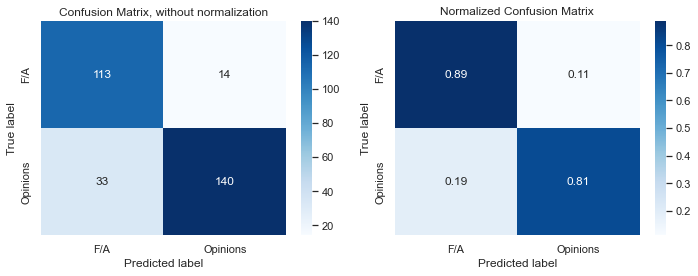

In [40]:
vmodel_best3c = vgrid.best_estimator_
vclf_pred = vmodel_best3c.predict(X_test_tfidf_base4)

# print(model_best2.score(corpus_test2,y_test2))
print(classification_report(y_test3,vclf_pred,target_names=labels3))
confusion_mat(y_test3,vclf_pred,labels3)

In [41]:
acc3b = accuracy_score(y_test3,vclf_pred)
f1_mac3b = f1_score(y_test3,vclf_pred,average='macro')
f1_w3b = f1_score(y_test3,vclf_pred,average='weighted')
miss3b = 1-acc3b
base_actual3b = round((acc3b-base3a)*100,2)

print("MODEL 3A SUMMARY -- VOTING CLASSIFIER:\n")
print('Null Accuracy (baseline):  ',base3a.round(3))
print('Accuracy (test data):  ',acc3b.round(3))
print('F1 Score (macro):  ',f1_mac3b.round(3))
print('F1 Score (weighted):  ',f1_w3b.round(3))
print('Misclassification Error-Rate:  ',miss3b.round(3))
print("\nModel 3a's accuracy on the test data is %0.2f%% better than the theoretical baseline  (null accuracy)"%(base_actual3b))

MODEL 3A SUMMARY -- VOTING CLASSIFIER:

Null Accuracy (baseline):   0.573
Accuracy (test data):   0.843
F1 Score (macro):   0.842
F1 Score (weighted):   0.844
Misclassification Error-Rate:   0.157

Model 3a's accuracy on the test data is 27.03% better than the theoretical baseline  (null accuracy)


### 5.1.5 Results

In [42]:
evals_step1 = pd.DataFrame({'(Step 1) Subjectivity Classifier Algorithm':['Logistic Regression','Ridge Classifier','Voting Ensemble'],
                            'Test Acc.':[acc3a1,acc3a2,acc3b],
                            'F1 (macro)':[f1_mac3a1,f1_mac3a2,f1_mac3b],
                            'F1 (weighted)':[f1_w3a1,f1_w3a2,f1_w3b],
                            'Error-Rate':[miss3a1,miss3a2,miss3b]}).set_index(['(Step 1) Subjectivity Classifier Algorithm'])

subsets = pd.IndexSlice[('Voting Ensemble'),evals_step1.columns[:]]
ev1 = evals_step1.style.format(precision=3).applymap(lambda x:"background-color:yellow",subset=subsets)
# dfi.export(ev1,'../images/evals_step1.png')
ev1

,Test Acc.,F1 (macro),F1 (weighted),Error-Rate
(Step 1) Subjectivity Classifier Algorithm,,,,
Logistic Regression,0.817,0.808,0.814,0.183
Ridge Classifier,0.820,0.814,0.819,0.180
Voting Ensemble,0.843,0.842,0.844,0.157


### 5.2 Pipeline (step 2): Sentiment Classifier

**Labels: Negative, Neutral, Positive**

<br>

***
- **Note:** In part 2 of the pipeline, I am now going to take the tweets that were classified as 'Opinions' using the Voting Ensemble of the Subjectivity Classifier and feed them into the Sentiment Model.
***

In [43]:
corpus_test1b = pd.DataFrame(corpus_test1)
testing = pd.DataFrame([corpus_test1,y_test1]).T

pred2 = pd.DataFrame({'clean_tweets':corpus_test3.values,'labels':vclf_pred})
pred2 = pred2[pred2.labels==1]
pred3 = corpus_test1b[corpus_test1b.clean_tweets.isin(pred2.clean_tweets)]
pred4 = testing[testing.index.isin(pred3.index)]
pred4['classes2'] = pd.to_numeric(pred4['classes2'])

test_counts1 = pd.DataFrame({'test filtered':pred4['classes2'].value_counts(),'test filtered %':pred4['classes2'].value_counts(normalize=True)})
test_counts2 = pd.DataFrame({'test original':y_test1.value_counts(),'test original %':y_test1.value_counts(normalize=True)})
test_counts3 = test_counts2.join(test_counts1,how='left')
test_counts3.index = ['Neutral','Positive','Negative']

base3b = test_counts3['test filtered %'].max()
# print("Baseline Accuracy = %0.2f %%"%(base3b*100))
test_counts3 

,test original,test original %,test filtered,test filtered %
Neutral,185,0.616667,61,0.396104
Positive,91,0.303333,78,0.506494
Negative,24,0.080000,15,0.097403


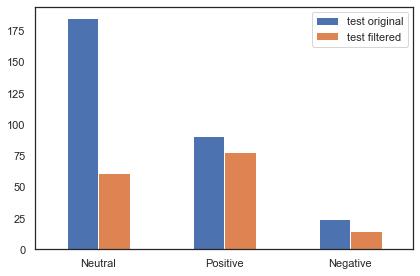

In [44]:
test_counts33 = test_counts3.reset_index()
test_counts33.plot(x='index',y=['test original','test filtered'],kind='bar').set(xlabel=None)
plt.xticks(rotation=0)
plt.tight_layout();

In [45]:
# Define pipeline
tfidf_lr_pipeline1a = Pipeline([
    ('tfidf',TfidfVectorizer()),
    ('lr',LogisticRegression())
])

grid_params1a = {
    'tfidf__max_df': [0.8],
    'tfidf__ngram_range': [(1,1),(1,2)],
    'tfidf__binary': [True],
    'tfidf__use_idf': [True],
    'tfidf__smooth_idf': [False,True],
    'lr__C': [0.1,1,10,100],
    'lr__solver': ['liblinear'],
    'lr__penalty': ['l2'],
    'lr__class_weight': ['balanced']
}

gs_tfidf_lr1a = GridSearchCV(tfidf_lr_pipeline1a,param_grid=grid_params1a,cv=5,n_jobs=-1,verbose=1)
gs_tfidf_lr1a.fit(corpus_train1,y_train1)

print("Best Score: ",gs_tfidf_lr1a.best_score_)
print("Best Paramaters: ",gs_tfidf_lr1a.best_params_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best Score:  0.7114285714285715
Best Paramaters:  {'lr__C': 1, 'lr__class_weight': 'balanced', 'lr__penalty': 'l2', 'lr__solver': 'liblinear', 'tfidf__binary': True, 'tfidf__max_df': 0.8, 'tfidf__ngram_range': (1, 1), 'tfidf__smooth_idf': False, 'tfidf__use_idf': True}


              precision    recall  f1-score   support

    Negative       0.60      0.20      0.30        15
     Neutral       0.69      0.92      0.79        61
    Positive       0.93      0.81      0.86        78

    accuracy                           0.79       154
   macro avg       0.74      0.64      0.65       154
weighted avg       0.80      0.79      0.78       154



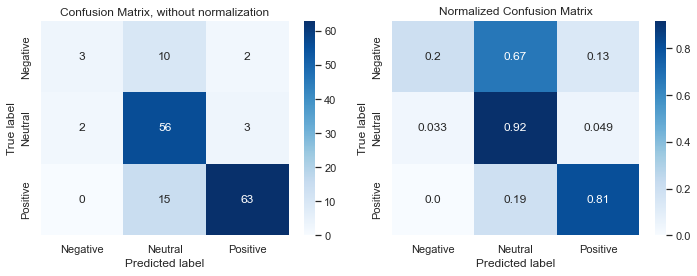

In [46]:
# Best TF-IDF/LogReg hyper parameters
best_model1a = gs_tfidf_lr1a.best_estimator_
y_pred_best_model1c = best_model1a.predict(pred4.clean_tweets)

# print(tfidf_gs_best.score(corpus_test, y_test))
print(classification_report(pred4.classes2,y_pred_best_model1c,target_names=labels))
confusion_mat(pred4.classes2,y_pred_best_model1c,labels)

### 5.3 Full System Summary (step 1 & step 2)

### 5.3.1 Aggregating Metrics 

In [47]:
# model 2
df_model2 = pd.DataFrame([corpus_test2,y_test2]).T
df_model2.insert(2,'model2',y_pred_best2)
# model 3a
df_model3a = pd.DataFrame([corpus_test3,y_test3]).T
df_model3a.insert(2,'model3a',vclf_pred)
# model 3b
df_model3b = pd.DataFrame([pred4.clean_tweets,pred4.classes2]).T
df_model3b.insert(2,'model3b',y_pred_best_model1c)
# combine model 3a and 3b
df_model3ab = df_model3a.copy()
df_model3ab.insert(3,'model3ab',df_model3b['model3b'])
df_model3ab['model3ab'] = df_model3ab['model3ab'].replace(np.nan,3).astype(int)
# compare model 2 and model 3a+b
df_compare2and3 = df_model2.copy()
df_compare2and3.insert(3,'model3ab',df_model3ab['model3ab'])
df_compare2and3.rename({'classes2':'true y','model2':'model 2: yhat','model3ab':'model 3: yhat'},axis='columns',inplace=True)
df_compare2and3['true y'] = df_compare2and3['true y'].astype(int)
df_compare2and3.sample(10)

,clean_tweets,true y,model 2: yhat,model 3: yhat
109,indiana kentucky are neck neck covidvaccine,1,0,3
859,facial swelling occurred in patient at the sit...,3,3,3
796,there are no american tank on baghdad the eu i...,3,1,3
349,you can forget about your covidvaccine sa roll...,0,1,3
303,my dad ha just made an appointment for his fir...,2,2,2
762,gopcomplicittraitors covidvaccine bbcnews gopd...,0,2,1
385,by liberallogic we should ban the vaccine righ...,1,1,1
905,covidvaccine you are so entitled i hope you ra...,1,2,1
890,all done covidvaccine thanksnhs,2,2,2
39,you cannot catch coronavirus from the covidvac...,1,0,1


              precision    recall  f1-score   support

    Negative       0.60      0.12      0.21        24
     Neutral       0.57      0.79      0.66        58
    Positive       0.93      0.69      0.79        91
         F/A       0.78      0.90      0.84       127

    accuracy                           0.75       300
   macro avg       0.72      0.63      0.62       300
weighted avg       0.77      0.75      0.74       300



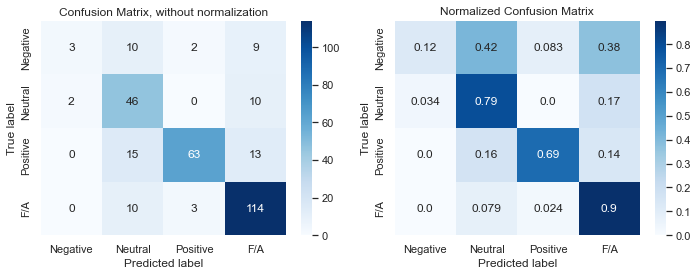

In [48]:
print(classification_report(df_compare2and3['true y'],np.array(df_compare2and3['model 3: yhat']),target_names=labels2))
confusion_mat(df_compare2and3['true y'],np.array(df_compare2and3['model 3: yhat']),labels2)

# cm3 = confusion_matrix(df_compare2and3['true y'],np.array(df_compare2and3['model 3: yhat']),normalize='true')
# plt.title("Model 3: Normalized Confusion Matrix")
# ax = sns.heatmap(cm3,annot=True,fmt='.2',cmap='Blues',yticklabels=labels2,xticklabels=labels2)
# ax.set(xlabel='Predicted label',ylabel='True label')
# # plt.savefig('../images/cm_image3.png')

In [49]:
acc4b = accuracy_score(df_compare2and3['true y'],np.array(df_compare2and3['model 3: yhat']))
f1_mac4b = f1_score(df_compare2and3['true y'],np.array(df_compare2and3['model 3: yhat']),average='macro')
f1_w4b = f1_score(df_compare2and3['true y'],np.array(df_compare2and3['model 3: yhat']),average='weighted')
miss4b = 1-acc4b
base_actual4b = round((acc4b-base2)*100,2)

print("MODEL 3 SUMMARY -- FULL SYSTEM W/ VOTING ENSEMBLE:\n")
print('Null Accuracy (baseline):  ', base2.round(3))
print('Accuracy (test data):  ', acc4b.round(3))
print('F1 Score (macro):  ',f1_mac4b.round(3))
print('F1 Score (weighted):  ',f1_w4b.round(3))
print('Misclassification Error-Rate:  ', miss4b.round(3))
print("\nModel 3's accuracy on the test data is %0.2f%% better than the theoretical baseline (null accuracy)"%(base_actual4b))

MODEL 3 SUMMARY -- FULL SYSTEM W/ VOTING ENSEMBLE:

Null Accuracy (baseline):   0.427
Accuracy (test data):   0.753
F1 Score (macro):   0.624
F1 Score (weighted):   0.738
Misclassification Error-Rate:   0.247

Model 3's accuracy on the test data is 32.63% better than the theoretical baseline (null accuracy)


### 5.3.2 Results

In [50]:
# LOGISTIC REGRESSION SUMMARY RESULTS
pred2a = pd.DataFrame({'clean_tweets':corpus_test3.values,'labels':y_pred_best3a})
pred2a = pred2a[pred2a.labels==1]
pred3a = corpus_test1b[corpus_test1b.clean_tweets.isin(pred2a.clean_tweets)]
pred4a = testing[testing.index.isin(pred3a.index)]
pred4a['classes2'] = pd.to_numeric(pred4a['classes2'])

best_model1a1 = gs_tfidf_lr1a.best_estimator_
y_pred_best_model1c1 = best_model1a1.predict(pred4a.clean_tweets)

df_model3a1 = pd.DataFrame([corpus_test3,y_test3]).T
df_model3a1.insert(2,'model3a',y_pred_best3a)
df_model3b1 = pd.DataFrame([pred4a.clean_tweets,pred4a.classes2]).T
df_model3b1.insert(2,'model3b',y_pred_best_model1c1)
df_model3ab1 = df_model3a1.copy()
df_model3ab1.insert(3,'model3ab',df_model3b1['model3b'])
df_model3ab1['model3ab'] = df_model3ab1['model3ab'].replace(np.nan,3).astype(int)
df_compare2and31 = df_model2.copy()
df_compare2and31.insert(3,'model3ab',df_model3ab1['model3ab'])
df_compare2and31.rename({'classes2':'true y','model2':'model 2: yhat','model3ab':'model 3: yhat'},axis='columns',inplace=True)
df_compare2and31['true y'] = df_compare2and31['true y'].astype(int)

acc4b1 = accuracy_score(df_compare2and31['true y'],np.array(df_compare2and31['model 3: yhat']))
f1_mac4b1 = f1_score(df_compare2and31['true y'],np.array(df_compare2and31['model 3: yhat']),average='macro')
f1_w4b1 = f1_score(df_compare2and31['true y'],np.array(df_compare2and31['model 3: yhat']),average='weighted')
miss4b1 = 1-acc4b1
base_actual4b1 = round((acc4b1-base2)*100,2)

# RIDGE CLASSIFIER SUMMARY RESULTS
pred2b = pd.DataFrame({'clean_tweets':corpus_test3.values,'labels':y_pred_best3b})
pred2b = pred2b[pred2b.labels==1]
pred3b = corpus_test1b[corpus_test1b.clean_tweets.isin(pred2b.clean_tweets)]
pred4b = testing[testing.index.isin(pred3b.index)]
pred4b['classes2'] = pd.to_numeric(pred4b['classes2'])

best_model1a2 = gs_tfidf_lr1a.best_estimator_
y_pred_best_model1c2 = best_model1a2.predict(pred4b.clean_tweets)

df_model3a2 = pd.DataFrame([corpus_test3,y_test3]).T
df_model3a2.insert(2,'model3a',y_pred_best3b)
df_model3b2 = pd.DataFrame([pred4b.clean_tweets,pred4b.classes2]).T
df_model3b2.insert(2,'model3b',y_pred_best_model1c2)
df_model3ab2 = df_model3a2.copy()
df_model3ab2.insert(3,'model3ab',df_model3b2['model3b'])
df_model3ab2['model3ab'] = df_model3ab2['model3ab'].replace(np.nan,3).astype(int)
df_compare2and32 = df_model2.copy()
df_compare2and32.insert(3,'model3ab',df_model3ab2['model3ab'])
df_compare2and32.rename({'classes2':'true y','model2':'model 2: yhat','model3ab':'model 3: yhat'},axis='columns',inplace=True)
df_compare2and32['true y'] = df_compare2and32['true y'].astype(int)

acc4b2 = accuracy_score(df_compare2and32['true y'],np.array(df_compare2and32['model 3: yhat']))
f1_mac4b2 = f1_score(df_compare2and32['true y'],np.array(df_compare2and32['model 3: yhat']),average='macro')
f1_w4b2 = f1_score(df_compare2and32['true y'],np.array(df_compare2and32['model 3: yhat']),average='weighted')
miss4b2 = 1-acc4b2
base_actual4b2 = round((acc4b2-base2)*100,2)

In [51]:
evals_step2 = pd.DataFrame({'(Step 2) Full System Algorithm Combination':['Logistic Regression | LR','Ridge Classifier | LR','Voting Ensemble | LR'],
                            'Test Acc.':[acc4b1,acc4b2,acc4b],
                            'F1 (macro)':[f1_mac4b1,f1_mac4b2,f1_mac4b],
                            'F1 (weighted)':[f1_w4b1,f1_w4b2,f1_w4b],
                            'Error-Rate':[miss4b1,miss4b2,miss4b]}).set_index(['(Step 2) Full System Algorithm Combination'])                                                                                          

subsets = pd.IndexSlice[('Voting Ensemble | LR'),evals_step2.columns[:]]
ev2 = evals_step2.style.format(precision=3).applymap(lambda x:"background-color:yellow",subset=subsets)
# dfi.export(ev2,'../images/evals_step2.png')
ev2

,Test Acc.,F1 (macro),F1 (weighted),Error-Rate
(Step 2) Full System Algorithm Combination,,,,
Logistic Regression | LR,0.693,0.588,0.695,0.307
Ridge Classifier | LR,0.700,0.591,0.699,0.300
Voting Ensemble | LR,0.753,0.624,0.738,0.247


## 6. Performance Metrics Evaluation

In [52]:
precision1,recall1,fscore1,support1 = precision_recall_fscore_support(y_test1, y_pred_best_model1)
precision2,recall2,fscore2,support2 = precision_recall_fscore_support(y_test2,y_pred_best2)
precision3,recall3,fscore3,support3 = precision_recall_fscore_support(df_compare2and3['true y'],np.array(df_compare2and3['model 3: yhat']))
precision4,recall4,fscore4,support4 = precision_recall_fscore_support(df_compare2and31['true y'],np.array(df_compare2and31['model 3: yhat']))
precision5,recall5,fscore5,support5 = precision_recall_fscore_support(df_compare2and32['true y'],np.array(df_compare2and32['model 3: yhat']))

model_name = ['Model 1: Reduced Sentiment Model','Model 2: Full Sentiment Model','Model 3: 2 Step Model','Model 3: 2 Step Model','Model 3: 2 Step Model']
alg_method = ['Logistic Regression','Logistic Regression','Logistic Regression | LR','Ridge Classifier | LR','Ensemble Voting | LR']
cols_idx = {'Prec_0':'Negative','F1_0':'Negative','Rec_0':'Negative','Prec_1':'Neutral','F1_1':'Neutral','Rec_1':'Neutral','Prec_2':'Positive','F1_2':'Positive','Rec_2':'Positive','Prec_3':'F/A','F1_3':'F/A','Rec_3':'F/A'}

final_evals1 = pd.DataFrame({'Model':model_name,
                      'Algorithm / Method':alg_method,
                      'Test Accuracy':[acc1,acc2,acc4b1,acc4b2,acc4b],
                      'Null Accuracy':[base1,base2,base2,base2,base2],
                      'Δ Acc.':['+'+str(base_actual1)+'%','+'+str(base_actual2)+'%','+'+str(base_actual4b1)+'%','+'+str(base_actual4b2)+'%','+'+str(base_actual4b)+'%'],
                      'Error-Rate':[miss1,miss2,miss4b1,miss4b2,miss4b]}).set_index(['Model','Algorithm / Method'])

final_evals2 = pd.DataFrame({'Model':model_name,
                      'Algorithm / Method':alg_method,
                      'Prec_0':[precision1[0],precision2[0],precision4[0],precision5[0],precision3[0]],
                      'Rec_0':[recall1[0],recall2[0],recall4[0],recall5[0],recall3[0]],
                      'F1_0':[fscore1[0],fscore2[0],fscore4[0],fscore5[0],fscore3[0]],
                      'Prec_1':[precision1[1],precision2[1],precision4[1],precision5[1],precision3[1]],
                      'Rec_1':[recall1[1],recall2[1],recall4[1],recall5[1],recall3[1]],
                      'F1_1':[fscore1[1],fscore2[1],fscore4[1],fscore5[1],fscore3[1]],
                      'Prec_2':[precision1[2],precision2[2],precision4[2],precision5[2],precision3[2]],
                      'Rec_2':[recall1[2],recall2[2],recall4[2],recall5[2],recall3[2]],
                      'F1_2':[fscore1[2],fscore2[2],fscore4[2],fscore5[2],fscore3[2]],
                      'Prec_3':['--',precision2[3],precision4[3],precision5[3],precision3[3]],
                      'Rec_3':['--',recall2[3],recall4[3],recall5[3],recall3[3]],
                      'F1_3':['--',fscore2[3],fscore4[3],fscore5[3],fscore3[3]]}).set_index(['Model','Algorithm / Method'])

final_evals2.columns = pd.MultiIndex.from_tuples([*zip(map(cols_idx.get,final_evals2),final_evals2)])

In [53]:
subsets = pd.IndexSlice[('Model 3: 2 Step Model','Ensemble Voting | LR'),final_evals1.columns[:]]
ev3 = final_evals1.style.format(precision=3).applymap(lambda x:"background-color:yellow",subset=subsets)
# dfi.export(ev3,'../images/final_evals1.png')
ev3

In [54]:
final_evals2.style.format(precision=3)

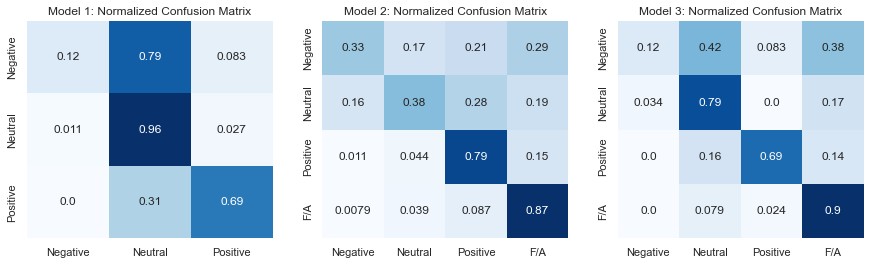

In [55]:
cm1 = confusion_matrix(y_test1,y_pred_best_model1,normalize='true')
cm2 = confusion_matrix(y_test2,y_pred_best2,normalize='true')
cm3 = confusion_matrix(df_compare2and3['true y'],np.array(df_compare2and3['model 3: yhat']),normalize='true')

fig, ax = plt.subplots(1,3,figsize=(15,4))
sns.heatmap(cm1,annot=True,fmt='.2',cmap='Blues',yticklabels=labels,xticklabels=labels,cbar=False,ax=ax[0])
sns.heatmap(cm2,annot=True,fmt='.2',cmap='Blues',yticklabels=labels2,xticklabels=labels2,cbar=False,ax=ax[1])
sns.heatmap(cm3,annot=True,fmt='.2',cmap='Blues',yticklabels=labels2,xticklabels=labels2,cbar=False,ax=ax[2])

ax[0].set_title('Model 1: Normalized Confusion Matrix')
ax[1].set_title('Model 2: Normalized Confusion Matrix')
ax[2].set_title('Model 3: Normalized Confusion Matrix')
# plt.savefig('../images/cm_image0.png')
plt.show();